## Part I

### Polynomial Regressions

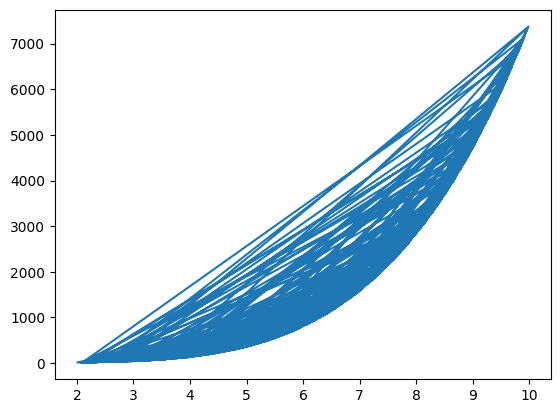

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a, b = 2, 10
n_samples = 300

x = np.random.uniform(a, b, n_samples)

# p(x) = b1x^4 + b2x^3 + b3x^2 + b4x + e
y = np.polyval([1, -3, 4, 2, -1], x) # polynomial data

noise = np.random.normal(0, 0.2, n_samples)

y = y + noise

plt.plot(x,y)

### Polynomial regression for a 2nd order polynomial model (no regularization)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, LearningCurveDisplay
from sklearn.metrics import mean_squared_error

poly_features = PolynomialFeatures(degree=2, include_bias=False)

X_poly = poly_features.fit_transform(x.reshape(-1,1))

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

X_poly[:10]

array([[ 6.11925685, 37.44530443],
       [ 4.5152769 , 20.38772553],
       [ 6.77654368, 45.9215442 ],
       [ 8.14464823, 66.33529484],
       [ 9.07897689, 82.42782138],
       [ 7.5858535 , 57.5451733 ],
       [ 2.54913931,  6.49811123],
       [ 3.97551051, 15.8046838 ],
       [ 2.15116644,  4.62751707],
       [ 8.22341806, 67.62460456]])

(41463.3714224782, 56373.26158284236)

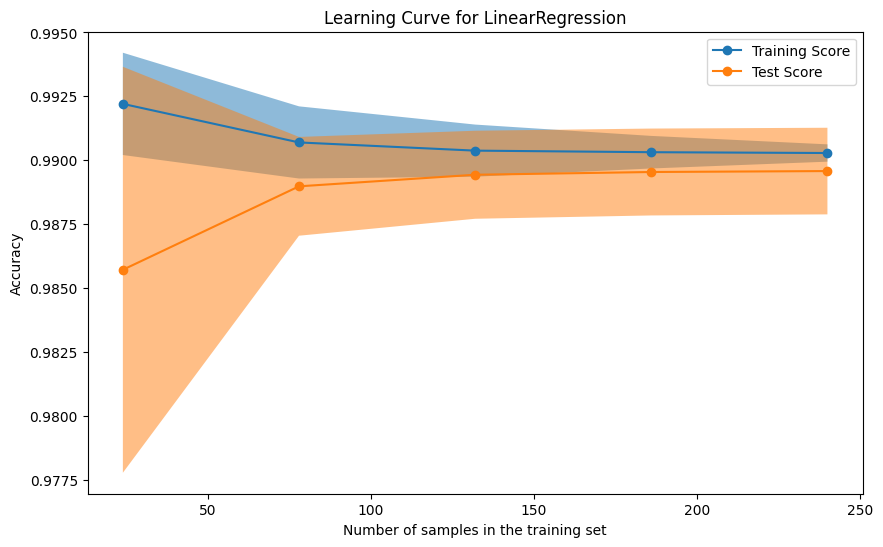

In [ ]:
# Training the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predicting on training and validation sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# MSE
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

# Plot
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

## learning curves show how the statistical performance of the model (in terms of training score and testing score) changes as the dataset size increases.
common_params = {
    "X": X_poly, # the method splits the full dataset k times in training and test data.
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 5), # Relative or absolute numbers of training examples that will be used to generate the learning curve
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "Accuracy",
}

## Scikit-learn uses the negative MSE as the loss function so we need to correct for the sign later
## source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html
LearningCurveDisplay.from_estimator(LinearRegression(), # new instantiation to avoid biasing training by passing a fitted model
                                    **common_params, ax=ax)
handles, label = ax.get_legend_handles_labels()
ax.legend(handles[:2], ["Training Score", "Test Score"])
ax.set_title(f"Learning Curve for {LinearRegression().__class__.__name__}")

train_error, test_error

### Polynomial regression for a 8th order polynomial model (no regularization)

(0.0354205490507452, 0.043002221126749646)

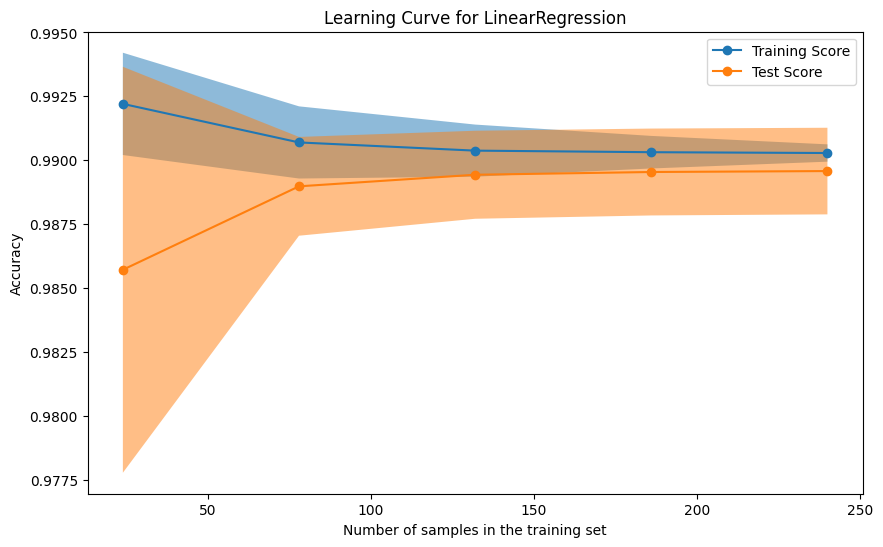

In [ ]:
poly_features8 = PolynomialFeatures(degree=8, include_bias=False)

X_poly8 = poly_features8.fit_transform(x.reshape(-1,1))

# Splitting the data into training and testing sets
X_train8, X_test8, y_train8, y_test8 = train_test_split(X_poly8, y,
                                                      test_size=0.2, random_state=42)

# train/fit
reg8 = LinearRegression()
reg8.fit(X_train8, y_train8)

# predict
y_train_pred8 = reg8.predict(X_train8)
y_test_pred8 = reg8.predict(X_test8)

# MSE
train_error8 = mean_squared_error(y_train8, y_train_pred8)
test_error8 = mean_squared_error(y_test8, y_test_pred8)

# Plotting learning curves
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

LearningCurveDisplay.from_estimator(LinearRegression(),
                                    **common_params, ax=ax2)

handles, label = ax2.get_legend_handles_labels()
ax2.legend(handles[:2], ["Training Score", "Test Score"])
ax2.set_title(f"Learning Curve for {LinearRegression().__class__.__name__}")

train_error8, test_error8

### 8-th order polynomial model with L1 regularization


In [ ]:
from sklearn.linear_model import Lasso, LassoCV
from sklearn.model_selection import cross_val_score

# Defining a range of lambda values to explore
# logarithmic is what seems to be the common choice in the literature for exploring parameter space
lambdas = np.logspace(-4, -0.5, 30)

# Calculating cross-validation errors
cv_errors = []

for lambda_hyp in lambdas:
    lasso_reg8 = Lasso(alpha=lambda_hyp, max_iter=10000)
    cv_error = -np.mean(cross_val_score(lasso_reg8, X_poly8, y,
                                        cv=5, scoring='neg_mean_squared_error'))
    cv_errors.append(cv_error)

### cross validation error vs regularizing parameter lambda

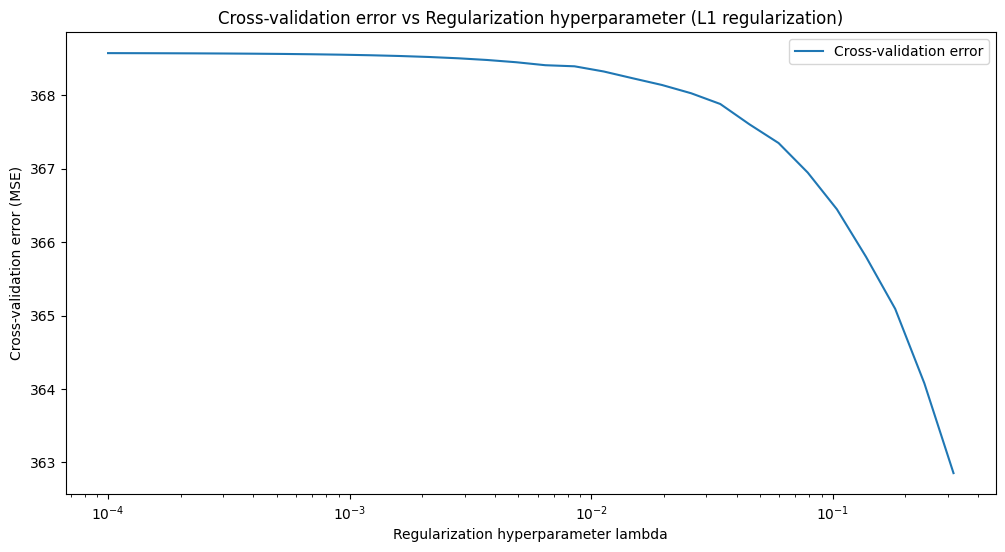

In [ ]:
# Plotting cross-validation error vs regularization hyperparameter lambda
plt.figure(figsize=(12, 6))
plt.plot(lambdas, cv_errors, label='Cross-validation error')
plt.xscale('log')
plt.xlabel('Regularization hyperparameter lambda')
plt.ylabel('Cross-validation error (MSE)')
plt.title('Cross-validation error vs Regularization hyperparameter (L1 regularization)')
plt.legend()

plt.show()

### Best value of lambda

In [ ]:
# Lasso linear model with iterative fitting along a regularization path.
# The best model is selected by cross-validation.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html

lasso_cv = LassoCV(alphas=lambdas, cv=5)
lasso_cv.fit(X_poly8, y)

lasso_cv.alpha_, lasso_cv.score(X_poly8, y)

(0.0001, 0.9999200216369184)

### L2 regularization for 8-th order polynomial model

In [ ]:
from sklearn.linear_model import Ridge, RidgeCV
import warnings
warnings.filterwarnings('ignore', message="Ill-conditioned matrix")

lambdas_ridge = np.logspace(-4, 4, 100)  # Extended range for Ridge
cv_errors_ridge = []

for lambda_hyp in lambdas_ridge:
    ridge_reg8 = Ridge(alpha=lambda_hyp)
    cv_error = -np.mean(cross_val_score(ridge_reg8, X_poly8, y, cv=5, scoring='neg_mean_squared_error'))
    cv_errors_ridge.append(cv_error)


### cross validation error vs regularizing parameter lambda

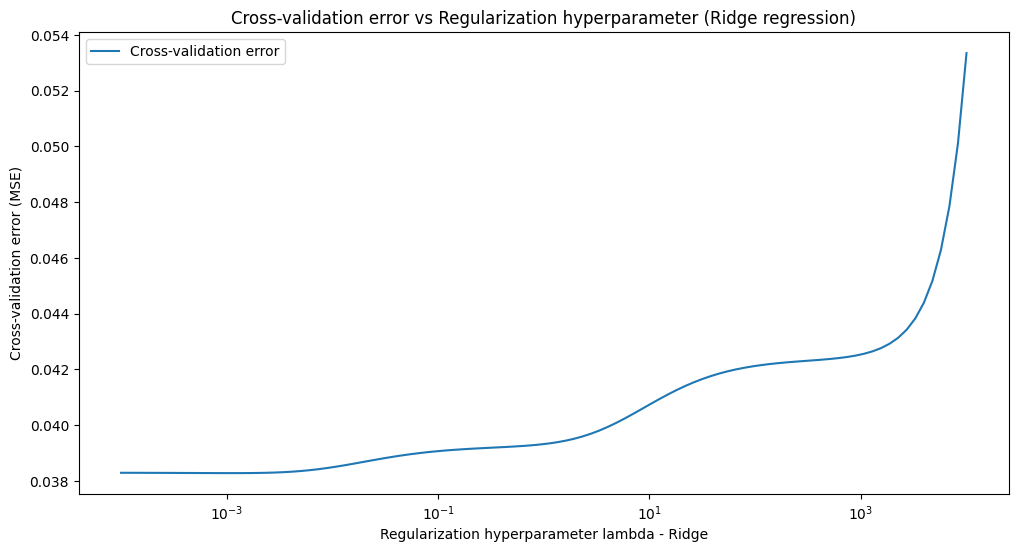

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(lambdas_ridge, cv_errors_ridge, label='Cross-validation error')
plt.xscale('log')
plt.xlabel('Regularization hyperparameter lambda - Ridge')
plt.ylabel('Cross-validation error (MSE)')
plt.title('Cross-validation error vs Regularization hyperparameter (Ridge regression)')
plt.legend()
plt.show()


### Best value of lambda.

In [ ]:
# Ridge regression with built-in cross-validation.
# By default, it performs efficient Leave-One-Out Cross-Validation.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html

ridge_cv = RidgeCV(alphas=lambdas_ridge, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_poly8, y)

ridge_cv.alpha_, ridge_cv.score(X_poly8, y)

(0.0011233240329780276, 0.9999999919232253)

### Compare results of 4 and 5.

- **Lasso** - 0.0001
- **Ridge** - 0.001123



### Use as a training set just 20 random points. Plot cross validation error vs the order of a polynomial model starting from order 2 and going to order 10 (do not use regularization).

In [ ]:
X = np.random.randn(20)

y = np.polyval([1, -3, 4, 2, -1], X) + np.random.normal(0, 0.2, 20)  # Generating y with noise

poly_orders = list(range(2, 11))
cv_errors_polys = []

for order in poly_orders:
    poly_features = PolynomialFeatures(degree=order, include_bias=False)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))

    model = LinearRegression()
    cv_error = -np.mean(cross_val_score(model, X_poly, y, cv=5, scoring='neg_mean_squared_error'))
    cv_errors_polys.append(cv_error)


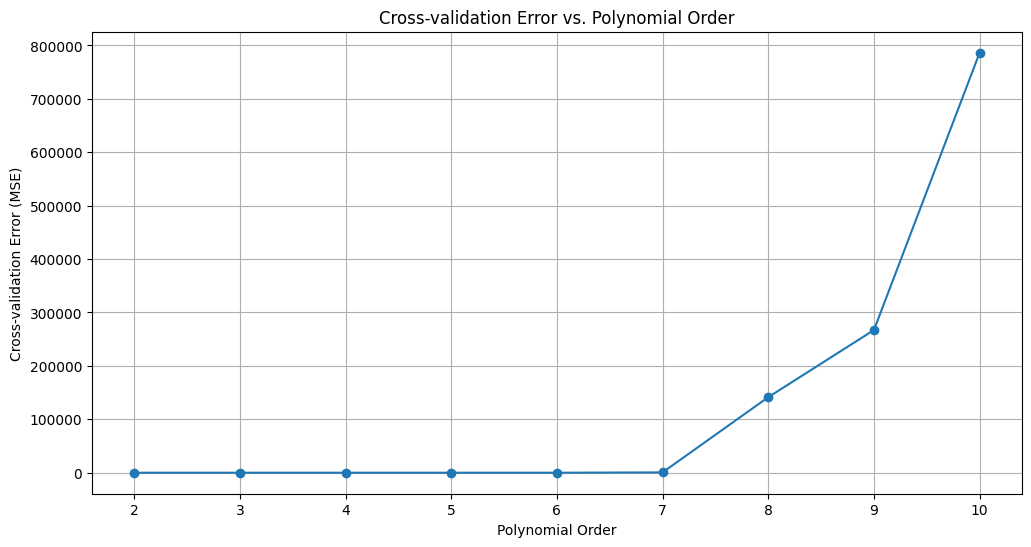

In [ ]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(poly_orders, cv_errors_polys, marker='o', linestyle='-')
plt.xlabel('Polynomial Order')
plt.ylabel('Cross-validation Error (MSE)')
plt.title('Cross-validation Error vs. Polynomial Order')
plt.xticks(poly_orders)
plt.grid(True)

plt.show()

## Part II

### Exercise 9

Exercise: Train a LinearSVC on a linearly separable dataset. Then train an SVC and a SGDClassifier on the same dataset. See if you can get them to produce roughly the same model.

**Data Preparation**: Utilized make_blobs from sklearn.datasets to generate a synthetic dataset with 1000 samples, divided into 2 clusters, each with 2 features. This dataset was then split into training and test sets.

**Unsupervised Clustering**: Applied KMeans clustering from sklearn.cluster to the training data without labels to identify two clusters. The clusters were visualized along with their centroids to confirm the separation.

**Cluster Evaluation**: The clustering was evaluated using metrics like inertia, silhouette score, Calinski-Harabasz score, and Davies-Bouldin score, providing insight into the clustering quality.

**Supervised Learning**: Two Logistic Regression models were trained separately on data from each cluster, effectively leveraging the unsupervised clustering as a preprocessing step.

**Selective Prediction and Evaluation**: Implemented a crucial step to assign test samples to clusters before using the appropriate model for prediction. This resulted in a more nuanced prediction strategy that considers the cluster affiliation of each test sample, likely reflecting the inherent data structure better than a one-size-fits-all model.

This exercise illustrated the power of combining unsupervised and supervised learning techniques to improve model performance. By clustering the data first and then training separate models on each cluster, we effectively tailored the learning process to the nuances of each data subset. This approach can be particularly useful in scenarios where the data naturally form distinct groups with potentially different predictive dynamics.

The high combined accuracy suggests that for the given dataset, this two-step approach was highly effective, likely because it allowed for more specialized models that could capture the unique characteristics of each cluster.

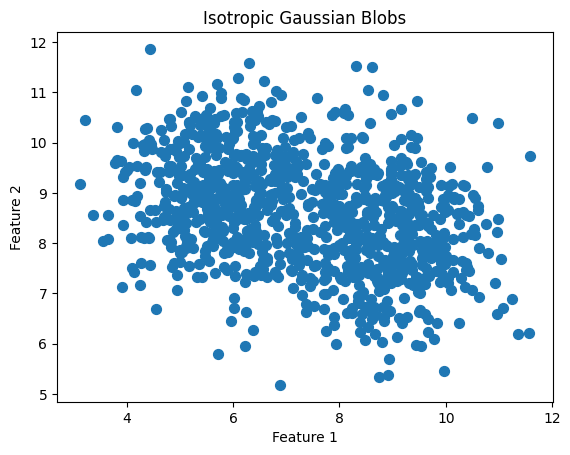

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets

X, y = datasets.make_blobs(n_samples=1000, centers=2, n_features=2,
                           center_box=(0, 10), random_state=20)

# no labels for unsupervised clustering
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Isotropic Gaussian Blobs")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


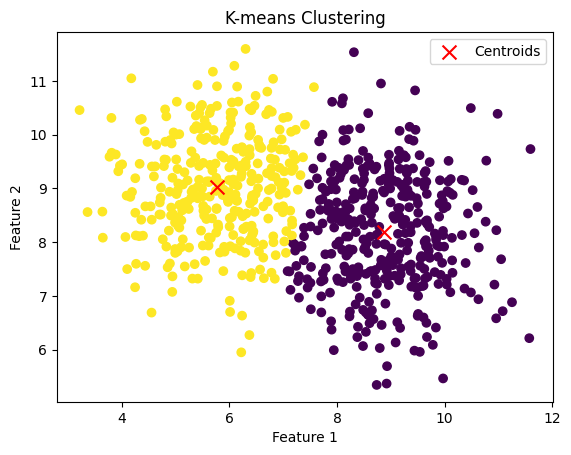

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create a KMeans model with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_train)

# Get the cluster labels for each data point
labels = kmeans.labels_
pred_labels = kmeans.predict(X_test)

# Visualize the clusters
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', color='red', s=100, label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('K-means Clustering')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_kmeans(model, X):
  """
  Evaluates a sklearn kmeans model.

  Args:
    model: A sklearn kmeans model.
    X: The data used to fit the model.

  Returns:
    A dictionary containing the following metrics:
      inertia: The sum of squared distances of samples to their closest cluster center.
      silhouette_score: The mean silhouette coefficient of all samples.
      calinski_harabasz_score: The Calinski-Harabasz score.
      davies_bouldin_score: The Davies-Bouldin score.
  """

  inertia = model.inertia_
  silhouette = silhouette_score(X, model.labels_)
  calinski_harabasz = calinski_harabasz_score(X, model.labels_)
  davies_bouldin = davies_bouldin_score(X, model.labels_)

  return {
    'inertia': inertia,
    'silhouette_score': silhouette,
    'calinski_harabasz_score': calinski_harabasz,
    'davies_bouldin_score': davies_bouldin
  }

evaluate_kmeans(kmeans, X_train)
# inertia suggests that the clusters may not be very well-separated.
# silh. suggests that the data points are fairly well-assigned to their clusters

{'inertia': 1283.7989530366815,
 'silhouette_score': 0.4957156765713078,
 'calinski_harabasz_score': 984.4017808874486,
 'davies_bouldin_score': 0.7563774270962731}

In [ ]:
labels.shape

(700,)

> train two models separately model 1 on cluster 1 of training data, model 2 on cluster 2 of training data

In [ ]:
y_train.shape, X_train.shape

((700,), (700, 2))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

cluster_1_indices = labels == 0
cluster_2_indices = labels == 1

X_cluster_1 = X_train[cluster_1_indices]
y_cluster_1 = y_train[cluster_1_indices]

X_cluster_2 = X_train[cluster_2_indices]
y_cluster_2 = y_train[cluster_2_indices]

In [ ]:
model_1 = LogisticRegression().fit(X_cluster_1, y_cluster_1)
model_2 = LogisticRegression().fit(X_cluster_2, y_cluster_2)

In [ ]:
X_train.shape

(700, 2)

In [ ]:
# Initialize an empty array to hold the final predictions
final_predictions = np.zeros_like(pred_labels)

# Use Model 1 for samples in Cluster 1 and Model 2 for samples in Cluster 2
for i in range(len(X_test)):
    if pred_labels[i] == 0:  # Cluster 1
        final_predictions[i] = model_1.predict(X_test[i].reshape(1, -1))[0]
    else:  # Cluster 2
        final_predictions[i] = model_2.predict(X_test[i].reshape(1, -1))[0]

predictions_model_1 = model_1.predict(X_test)
predictions_model_2 = model_2.predict(X_test)

# Calculate the accuracy of each model on the entire test set
accuracy_model_1 = accuracy_score(y_test, predictions_model_1)
accuracy_model_2 = accuracy_score(y_test, predictions_model_2)

# Print out the accuracies for comparison
print(f'Accuracy of Model 1 on the entire test set: {accuracy_model_1}')
print(f'Accuracy of Model 2 on the entire test set: {accuracy_model_2}')

# Evaluate the combined model accuracy
combined_accuracy = accuracy_score(y_test, final_predictions)
print(f'Combined Model Accuracy: {combined_accuracy}')

Accuracy of Model 1 on the entire test set: 0.9333333333333333
Accuracy of Model 2 on the entire test set: 0.9033333333333333
Combined Model Accuracy: 0.9466666666666667


The combined model accuracy surpasses the accuracy of either model used individually across the entire test set. This indicates that the strategy of clustering the data and then applying the most appropriate model based on the cluster assignment effectively leverages the underlying data structure to improve prediction accuracy.

Remainder of Exercise 9 - SVR with labeled linearly separable data

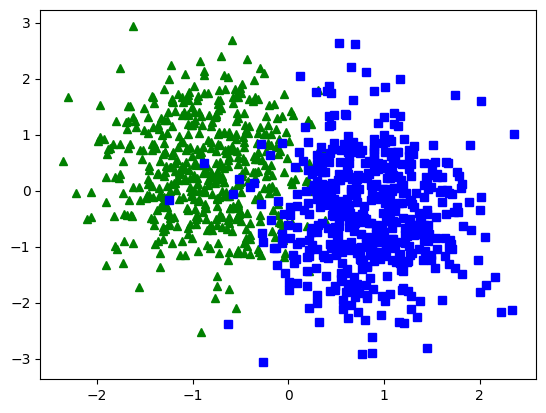

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 0.05

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

plt.plot(X_scaled[:, 0][y == 0], X_scaled[:, 1][y == 0], 'g^')
plt.plot(X_scaled[:, 0][y == 1], X_scaled[:, 1][y == 1], 'bs')
plt.show()

In [ ]:
lin_clf = LinearSVC(loss="hinge", C=C, dual=True, random_state=42).fit(X_scaled, y)
svc_clf = SVC(kernel="linear", C=C).fit(X_scaled, y)
sgd_clf = SGDClassifier(alpha=alpha, random_state=42).fit(X_scaled, y)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


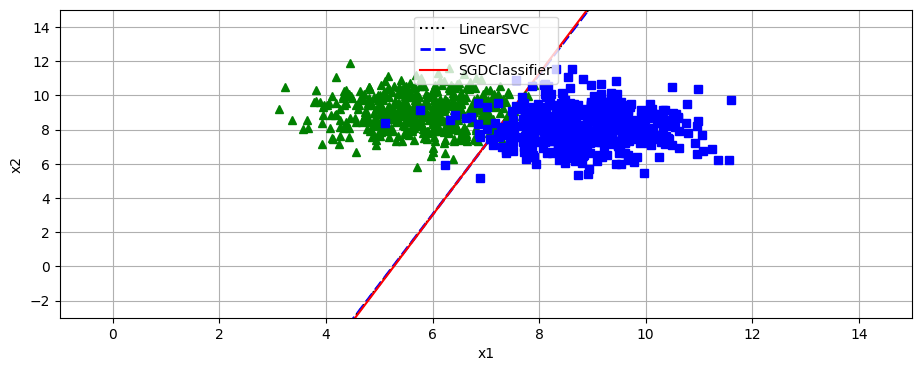

In [ ]:
def compute_decision_boundary(model):
    w = -model.coef_[0, 0] / model.coef_[0, 1]
    b = -model.intercept_[0] / model.coef_[0, 1]
    return scaler.inverse_transform([[-10, -10 * w + b], [10, 10 * w + b]])

lin_line = compute_decision_boundary(lin_clf)
svc_line = compute_decision_boundary(svc_clf)
sgd_line = compute_decision_boundary(sgd_clf)

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(lin_line[:, 0], lin_line[:, 1], "k:", label="LinearSVC")
plt.plot(svc_line[:, 0], svc_line[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(sgd_line[:, 0], sgd_line[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y == 0], X[:, 1][y == 0], 'g^')
plt.plot(X[:, 0][y == 1], X[:, 1][y == 1], 'bs')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend(loc="upper center")
plt.axis([-1, 15, -3, 15])
plt.grid()

plt.show()

### Exercise 10

Exercise: Train an SVM classifier on the Wine dataset, which you can load using sklearn.datasets.load_wine(). This dataset contains the chemical analysis of 178 wine samples produced by 3 different cultivators: the goal is to train a classification model capable of predicting the cultivator based on the wine's chemical analysis. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 3 classes. What accuracy can you reach?

**Dataset Preparation**: The code begins with generating a synthetic dataset using make_blobs, creating 500 samples with 2 features each, divided into 2 centers. This dataset is visualized using a scatter plot, distinguishing the two groups with different markers and colors.

**Data Splitting**: The dataset is split into training and test sets using train_test_split, preparing it for model training and evaluation.

**SVM Training with Linear Kernel**: A pipeline comprising StandardScaler for feature scaling and LinearSVC for SVM classification with a linear kernel is created and fitted to the training data.

**Cross-Validation for Linear SVM**: The model's performance is evaluated using cross-validation with the training data, reporting the mean accuracy across folds.

**SVM Training with RBF Kernel**: Another pipeline is set up, this time using SVC with the default RBF kernel, and its performance is also evaluated using cross-validation on the training set.

**Hyperparameter Tuning**: The code then moves to optimize the hyperparameters of the RBF kernel SVM using RandomizedSearchCV with a specified distribution for gamma and C parameters. This process aims to find the best combination of parameters that yields the highest cross-validation accuracy.

**Model Evaluation**: Finally, the best estimator found by the randomized search is evaluated on the test set to report its accuracy.

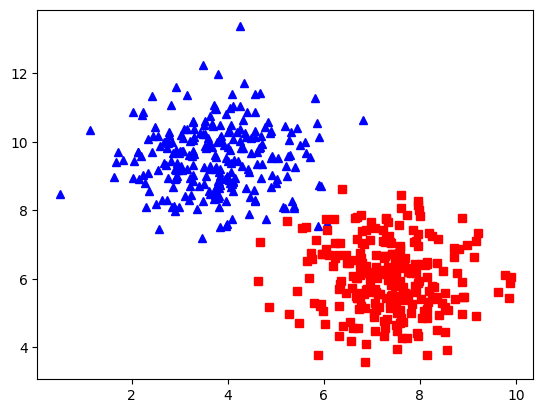

In [ ]:
# a more challenging dataset
X2, y2 = datasets.make_blobs(n_samples=500, centers=2, n_features=2, center_box=(0, 10), random_state=42)
plt.plot(X2[:, 0][y2 == 0], X2[:, 1][y2 == 0], 'b^')
plt.plot(X2[:, 0][y2 == 1], X2[:, 1][y2 == 1], 'rs')

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=42)

lin_clf = make_pipeline(StandardScaler(),
                        LinearSVC(dual=True, random_state=42))
lin_clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc', LinearSVC(random_state=42))])

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(lin_clf, X_train, y_train).mean()

0.9866666666666667

In [ ]:
svm_clf = make_pipeline(StandardScaler(), SVC(random_state=42))
cross_val_score(svm_clf, X_train, y_train).mean()

0.9893333333333333

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

param_distrib = {
    "svc__gamma": loguniform(0.001, 0.1),
    "svc__C": uniform(1, 10)
}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distrib, n_iter=100, cv=5,
                                   random_state=42)
rnd_search_cv.fit(X_train, y_train)
rnd_search_cv.best_estimator_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc',
                 SVC(C=1.5808361216819946, gamma=0.05399484409787434,
                     random_state=42))])

In [ ]:
rnd_search_cv.best_score_, rnd_search_cv.score(X_test, y_test)

(0.992, 1.0)

### Exercise 11

Exercise: Train and fine-tune an SVM regressor on the California housing dataset. You can use the original dataset rather than the tweaked version we used in Chapter 2. The original dataset can be fetched using sklearn.datasets.fetch_california_housing(). The targets represent hundreds of thousands of dollars. Since there are over 20,000 instances, SVMs can be slow, so for hyperparameter tuning you should use much less instances (e.g., 2,000), to test many more hyperparameter combinations. What is your best model's RMSE?

**Data Preparation**: The initial part of the code, which plots synthetic data, does not relate to the Wine dataset task. For the actual exercise, it's implied that the Wine dataset should be loaded and split into training and test sets.

**Model Training**: Two pipelines are created for training SVM classifiers. The first pipeline employs a LinearSVC with standard scaling of features, while the second utilizes SVC with a standard scaler. The use of pipelines ensures that preprocessing steps are appropriately applied within the cross-validation process, maintaining data integrity and preventing data leakage.

**Model Evaluation and Hyperparameter Tuning**: Cross-validation scores are calculated for both models to assess their performance. Further, a RandomizedSearchCV is employed on the second model (SVC) to explore a wide range of hyperparameters (C and gamma) efficiently, aiming to optimize the model's performance.

**Result Analysis**: The best estimator from the hyperparameter tuning process is identified, along with its performance metrics (cross-validation score and test set accuracy).

In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. Generate a synthetic dataset
X, y = make_regression(n_samples=10000, n_features=20, noise=0.1, random_state=42)

# 2. Prepare the dataset: Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3 & 4 are incorporated in the pipeline step below

# 5. Create a Pipeline
# This pipeline standardizes the data and then applies the SVR model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# 6. Cross-validation and Hyperparameter Tuning
# Define parameter grid
param_grid = {
    'svr__C': [0.1, 1, 10],
    'svr__gamma': ['scale', 'auto'],
    'svr__kernel': ['linear', 'rbf']
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                           scoring='neg_mean_squared_error', verbose=1)

# Fit the model
grid_search.fit(X_train[:3000], y_train[:3000])

# 7. Compute RMSE on the best model found
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print("Best Model Parameters:", grid_search.best_params_)
print("Test RMSE of the best model:", rmse)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Model Parameters: {'svr__C': 10, 'svr__gamma': 'scale', 'svr__kernel': 'linear'}
Test RMSE of the best model: 0.10187083501613653


**Best Model Parameters**: The best performing model utilized a C value of 10, gamma set to 'scale', and a 'linear' kernel. This combination suggests that a higher penalty (C) on the error term and the use of a linear kernel were most effective for this dataset, with 'scale' as the strategy for gamma indicating that the default scaling by the number of features was appropriate.

**Test RMSE**: The Root Mean Squared Error (RMSE) on the test set was reported as approximately 0.1019. This metric is crucial for understanding the model's predictive accuracy in the context of the target's scale. Given that RMSE values are in the same units as the target variable, this low RMSE value suggests that the best model achieved a high degree of accuracy in predicting the synthetic dataset's target values.